In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [2]:
#Define the number of elements in each set I, J, K
i_num = 15
k_num = 2
j_num = 200 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [3]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 5000), 0)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 5000), 0)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 5000), 0)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 5000), 0)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 5000), 0)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 5000), 0)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
J

,Point number,Latitude,Longitude
Point number,,,
j0,j0,2419.0,566.0
j1,j1,3918.0,1827.0
j2,j2,3447.0,3011.0
j3,j3,3180.0,2898.0
j4,j4,1967.0,534.0
...,...,...,...
i25,i25,205.0,1555.0
i26,i26,4312.0,281.0
i27,i27,4544.0,392.0


In [4]:
# ### PASSAU  ###

# #Define sets of I, J, K, where J contains I and K for Passau

# #Define the number of elements in each set I, J, K

# degree_to_m = 111111

# #Define empty data frames
# I_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# J_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
# K_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])

# column_types = {
#     'Name': 'str',  # Example: 'int', 'float', 'str', 'datetime64[ns]', etc.
#     'Latitude': 'float',
#     'Longitude': 'float',
#     'Address': 'str'
#     # Add more columns and their data types as needed
# }

# doctors = pd.read_csv('Doctors coordinates.txt', sep = ';', index_col = False, dtype=column_types)

# doctors

# for i in range(len(doctors['Latitude'])):
#     I_coordinates.loc[i, 'Point number'] = 'i'+ str(i)
#     I_coordinates.loc[i, 'Latitude'] = doctors.loc[i, 'Latitude']
#     I_coordinates.loc[i, 'Longitude'] = doctors.loc[i, 'Longitude']

# I_coordinates.index = I_coordinates['Point number']

# I = I_coordinates * degree_to_m
# I['Point number'] = I_coordinates['Point number']


# labs = pd.read_csv('Labs coordinates.txt', sep = ';', index_col = False, dtype=column_types) 
# labs

# for k in range(len(labs['Latitude'])):
#     K_coordinates.loc[k, 'Point number'] = 'k'+ str(k)
#     K_coordinates.loc[k, 'Latitude'] = labs.loc[k, 'Latitude']
#     K_coordinates.loc[k, 'Longitude'] = labs.loc[k, 'Longitude']

# K_coordinates.index = K_coordinates['Point number']

# K = K_coordinates * degree_to_m
# K['Point number'] = K_coordinates['Point number']


# #Define range of coordinates

# combined_coordinates = pd.concat([I_coordinates, K_coordinates])

# min_latitude = combined_coordinates['Latitude'].min()
# max_latitude = combined_coordinates['Latitude'].max()
# min_longitude = combined_coordinates['Longitude'].min()
# max_longitude = combined_coordinates['Longitude'].max()

# grid_spacing = 0.0018

# # Create grid points
# grid_points = []
# for lat in np.arange(min_latitude, max_latitude + grid_spacing, grid_spacing):
#     for lon in np.arange(min_longitude, max_longitude + grid_spacing, grid_spacing):
#         grid_points.append((round(lat, 6), round(lon, 6)))

# J_coordinates = pd.DataFrame(grid_points, columns=['Latitude', 'Longitude'])
# J_coordinates['Point number'] = ['j' + str(i) for i in range(len(J_coordinates))]

# J_coordinates.index = J_coordinates['Point number'] 
# J_coordinates = pd.concat([J_coordinates, K_coordinates, I_coordinates], axis = 0) #Include K to J

# river = ['j972', 'j973', 'j918', 'j919', 'j920', 'j866', 'j867', 'j813', 'j814',
# 'j815', 'j760', 'j761', 'j762', 'j707', 'j708', 'j709', 'j710', 'j654',
# 'j655', 'j656', 'j657', 'j658', 'j606', 'j610', 'j611', 'j612', 'j613', 'j614',
# 'j615', 'j616', 'j620', 'j621', 'j622', 'j623', 'j624', 'j625', 'j682', 'j683',
# 'j684','j685','j686', 'j635', 'j636', 'j637', 'j638', 'j585', 'j586', 'j587', 
# 'j588', 'j589', 'j590', 'j591', 'j592','j593', 'j531', 'j530', 'j529', 'j528',
# 'j527', 'j22', 'j23', 'j77', 'j132', 'j133', 'j134', 'j189', 'j190', 'j244',
# 'j245', 'j300', 'j301', 'j356', 'j411', 'j412', 'j467', 'j523', 'j524', 'j525', 'j526',

# 'j246', 'j247', 'j191', 'j192', 'j193', 'j194', 'j135', 'j136', 'j137', 'j138', 'j139',
# 'j140', 'j141', 'j78', 'j79', 'j80', 'j81', 'j82', 'j83', 'j84', 'j85', 'j86', 'j87', 'j88',
# 'j24', 'j25', 'j26', 'j27', 'j28', 'j29', 'j30', 'j31', 'j32', 'j33', 'j34', 'j35', 'j36',
#  'j261', 'j262', 'j263', 'j264', 'j266', 'j267', 'j268', 'j269', 'j206', 'j207', 'j208',
# 'j209', 'j210', 'j211', 'j212', 'j213', 'j214', 'j215', 'j153', 'j154', 'j155', 'j156',
# 'j157', 'j158', 'j159', 'j160', 'j161', 'j98', 'j99', 'j100', 'j101', 'j102', 'j103', 
# 'j104', 'j105', 'j106', 'j107', 'j43', 'j44', 'j45', 'j46', 'j47', 'j48', 'j49', 'j50', 
# 'j51', 'j52', 'j53'
#  ]

# J_coordinates = J_coordinates.drop(index = river) #excluding locations on the river

# J = J_coordinates * degree_to_m
# J['Point number'] = J_coordinates['Point number']
# J


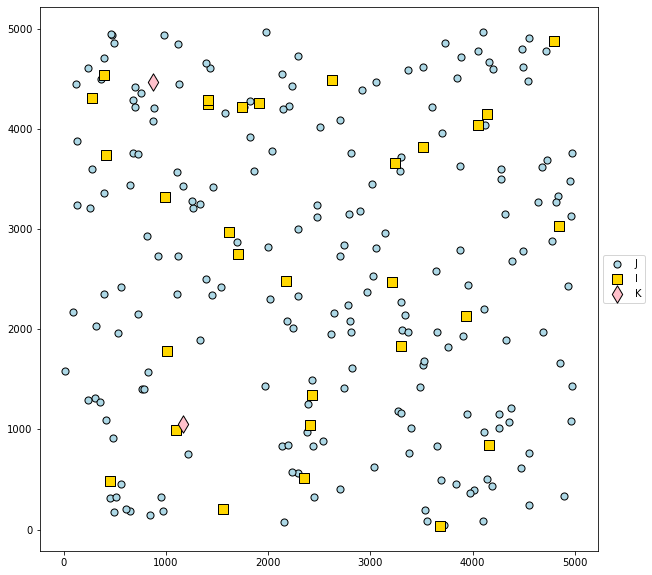

In [5]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [6]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib



# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Making Passau polygon

# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)

# passau_poly = shapely.wkt.loads(polygon_str)
# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# folium.GeoJson(passau_gdf).add_to(passau_map)


# # Assuming I_coordinates is your DataFrame with doctor coordinates
# geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.Marker([row['Latitude'], row['Longitude']], 
#                   icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1), 
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    
# geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_labs.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.Marker([row['Latitude'], row['Longitude']], 
#                   icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1, 
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    
# geo_bases = gpd.GeoDataFrame(J_coordinates, geometry=gpd.points_from_xy(J_coordinates["Latitude"], J_coordinates["Longitude"]), crs="epsg:4326")

# for idx, row in geo_bases.iterrows():
#     coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#     folium.CircleMarker([row['Latitude'], row['Longitude']],  
#                   popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)


# #Custom legend

# legend_html = '''
#      <div style="position: fixed; 
#                  bottom: 100px; right: 100px; width: 300px; height: 150px; 
#                  border:2px solid grey; z-index:9999; font-size:16px;
#                  background-color:white; opacity: 0.9;
#                  ">
#      &nbsp; <i class="fa fa-map-marker fa-3x" style="color:orange"></i> Doctors &nbsp; <br>
#      &nbsp; <i class="fa fa-map-marker fa-3x" style="color:red"></i> Laboratories &nbsp; <br>
#      &nbsp; <svg height="40" width="40">
#           <circle cx="20" cy="20" r="18" fill="none" stroke="#3388FF" stroke-width="2" />
#         </svg> Bases &nbsp; 
#       </div>
#      '''



# # Add the legend to the map
# passau_map.get_root().html.add_child(folium.Element(legend_html))

# passau_map

In [29]:
#Define constants

B = 91800 #battery load: meters of travel
S = 5100 #meters of service time

p = 0.98

alpha = 15900 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 203000
    else:
        beta[j] = 76920
        
gamma = 0.0045 / 1000 # variable cost in euro per m
        
q_j = {}
for j in J.index:
    if j.startswith('j'):
        q_j[j] = 255
    else:
        q_j[j] = 45



softlimit = 60
hardlimit = 10000

In [ ]:
#Model termination function

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()

In [8]:
up_bound = 10
mu = {i : int(round(random.uniform(1, up_bound), 0)) for i in I.index}

Deterministic model

In [9]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 2,
 'i1': 3,
 'i2': 0,
 'i3': 6,
 'i4': 0,
 'i5': 0,
 'i6': 1,
 'i7': 0,
 'i8': 7,
 'i9': 4,
 'i10': 6,
 'i11': 5,
 'i12': 3,
 'i13': 1,
 'i14': 12,
 'i15': 9,
 'i16': 6,
 'i17': 3,
 'i18': 3,
 'i19': 13,
 'i20': 7,
 'i21': 7,
 'i22': 9,
 'i23': 7,
 'i24': 3,
 'i25': 7,
 'i26': 7,
 'i27': 4,
 'i28': 9,
 'i29': 4}

In [10]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Longitude'], PointsSet1.loc[point1, 'Latitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Longitude'], PointsSet2.loc[point2, 'Latitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 1494.3868307770917,
 ('k0', 'j1'): 2938.9198696119633,
 ('k0', 'j2'): 3018.800589638209,
 ('k0', 'j3'): 2739.197875291232,
 ('k0', 'j4'): 1114.6479264772352,
 ('k0', 'j5'): 881.1129326028531,
 ('k0', 'j6'): 4323.082233777192,
 ('k0', 'j7'): 3623.315884655932,
 ('k0', 'j8'): 1297.482177141559,
 ('k0', 'j9'): 2156.0939218874487,
 ('k0', 'j10'): 1013.7282673379489,
 ('k0', 'j11'): 4492.554395886598,
 ('k0', 'j12'): 4311.547402035608,
 ('k0', 'j13'): 3789.8654329672445,
 ('k0', 'j14'): 3672.7455670111426,
 ('k0', 'j15'): 986.6128926787851,
 ('k0', 'j16'): 2385.8132785278904,
 ('k0', 'j17'): 3137.2513447283754,
 ('k0', 'j18'): 1694.4264516348887,
 ('k0', 'j19'): 2864.971378565587,
 ('k0', 'j20'): 1463.9306677571858,
 ('k0', 'j21'): 626.5476837400327,
 ('k0', 'j22'): 2375.9808500911786,
 ('k0', 'j23'): 3992.818803802647,
 ('k0', 'j24'): 4891.603929183147,
 ('k0', 'j25'): 761.2154754075879,
 ('k0', 'j26'): 2226.5104985155585,
 ('k0', 'j27'): 1390.8806562750092,
 ('k0', 'j28'): 

In [33]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, int(v.X)))
                                #print(v)
                print("\n")
                
        print("\n")
        

Number of solutions found: 9
0
2.5562e+06 
x_ikj[i0,k0,j5] 2
x_ikj[i1,k0,j5] 3
x_ikj[i3,k0,j5] 6
x_ikj[i6,k0,j5] 1
x_ikj[i8,k0,j5] 7
x_ikj[i9,k0,j5] 4
x_ikj[i10,k0,j5] 6
x_ikj[i11,k0,j5] 5
x_ikj[i12,k0,j5] 3
x_ikj[i13,k0,j5] 1
x_ikj[i14,k0,j5] 12
x_ikj[i15,k0,j5] 9
x_ikj[i16,k0,j5] 6
x_ikj[i17,k0,j5] 3
x_ikj[i18,k0,j5] 3
x_ikj[i19,k0,j5] 13
x_ikj[i20,k1,j5] 7
x_ikj[i21,k1,j5] 7
x_ikj[i22,k0,j5] 9
x_ikj[i23,k0,j5] 7
x_ikj[i24,k0,j5] 3
x_ikj[i25,k0,j5] 7
x_ikj[i26,k1,j5] 7
x_ikj[i27,k1,j5] 4
x_ikj[i28,k0,j5] 9
x_ikj[i29,k0,j5] 4
y_j[j5] 1


1
2.7592e+06 
x_ikj[i0,k0,j5] 2
x_ikj[i1,k0,j5] 3
x_ikj[i3,k0,j5] 6
x_ikj[i6,k0,j5] 1
x_ikj[i8,k0,j5] 7
x_ikj[i9,k0,j5] 4
x_ikj[i10,k0,j5] 6
x_ikj[i11,k0,j5] 5
x_ikj[i12,k0,j5] 3
x_ikj[i13,k0,j5] 1
x_ikj[i14,k0,j5] 12
x_ikj[i15,k0,j5] 9
x_ikj[i16,k0,j5] 6
x_ikj[i17,k0,j5] 3
x_ikj[i18,k0,j5] 3
x_ikj[i19,k0,j5] 13
x_ikj[i20,k1,j5] 7
x_ikj[i21,k1,j5] 7
x_ikj[i22,k0,j5] 9
x_ikj[i23,k0,j5] 7
x_ikj[i24,k0,j5] 3
x_ikj[i25,k0,j5] 7
x_ikj[i26,k1,j5] 7
x_ikj[i2

In [32]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    total_drones = sum(results['Number of drones'])
    total_locations = results['j'].nunique()
    return results_doctors, results_locations, results_labs, f'Total number of drones: {total_drones}', f'Total number of locations: {total_locations}'


(      i  Number of drones
 0    i0                 2
 1    i1                 3
 2   i10                 6
 3   i11                 5
 4   i12                 3
 5   i13                 1
 6   i14                12
 7   i15                 9
 8   i16                 6
 9   i17                 3
 10  i18                 3
 11  i19                13
 12  i20                 7
 13  i21                 7
 14  i22                 9
 15  i23                 7
 16  i24                 3
 17  i25                 7
 18  i26                 7
 19  i27                 4
 20  i28                 9
 21  i29                 4
 22   i3                 6
 23   i6                 1
 24   i8                 7
 25   i9                 4,
     j  Number of drones
 0  j5               148,
     k  Number of drones
 0  k0               123
 1  k1                25,
 'Total number of drones: 148',
 'Total number of locations: 1')

In [31]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (20, 20))
                
        fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Longitude'][i] - 40, I['Latitude'][i] - 15))
                
        fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Longitude'][k] - 40, K['Latitude'][k] - 15))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        (J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.plot((I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        #(I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                         #color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                #(K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                                fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                (J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

#SolutionGraph(I, K, J, model_det)

In [22]:
# def SolutionMap(I_coordinates, K_coordinates, J_coordinates, model):
        
#         with open('Polygon Passau.txt', 'r') as file:
#         # Read the contents of the file into a string
#                 polygon_str = file.read()

#         # Making Passau polygon
#         passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
#         passau_poly = shapely.wkt.loads(polygon_str)
#         passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
#         folium.GeoJson(passau_gdf).add_to(passau_map)

#         # Assuming I_coordinates is your DataFrame with doctor coordinates
#         geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326") 
        
#         indices_xi = []
#         indices_y = pd.DataFrame(columns = ['Location name', 'Latitude', 'Longitude'])
#         indices_x = pd.DataFrame(columns = ['I', 'J', 'Number of drones'])
        
        
#         i = 0
#         for v in model.getVars():
#                 if v.x > 0:
#                         if v.varName.startswith('x_ikj'):
#                                 indices_xi = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
#                                 indices_x.loc[i, 'I'] = str(indices_xi[0])
#                                 indices_x.loc[i, 'J'] = str(indices_xi[2])
#                                 indices_x.loc[i, 'Number of drones'] = int(v.x)
#                                 i += 1
                                
#                         else:
#                                 y_name = v.varName[4:-1]
#                                 indices_y.loc[str(y_name), 'Latitude'] = J_coordinates.loc[str(y_name), 'Latitude']
#                                 indices_y.loc[str(y_name), 'Longitude'] = J_coordinates.loc[str(y_name), 'Longitude']
#                                 indices_y.loc[str(y_name), 'Location name'] = str(y_name)
#                                 # 
#                                 # fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
#                                 #         edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                        
#         geo_solution_y = gpd.GeoDataFrame(indices_y, geometry=gpd.points_from_xy(indices_y["Latitude"], indices_y["Longitude"]), crs="epsg:4326")
        
        
        
#         for idx, row in geo_doctors.iterrows():
#                 coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']], 
#                         icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1), 
#                         popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
                
        
        
#         geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

#         for idx, row in geo_labs.iterrows():
#                 coordinates_label = f"Loc: {row['Point number']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']], 
#                                 icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1, 
#                                 popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
        
       
#         for idx, row in geo_solution_y.iterrows():
#                 coordinates_label = f"Loc: {row['Location name']}, Lat: {row['Latitude']}, Long: {row['Longitude']}"
#                 folium.Marker([row['Latitude'], row['Longitude']], 
#                         icon=folium.Icon(icon='circle', prefix='fa', color='green', size = 0.1), 
#                         popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
        
        
#         for idx, row in indices_x.iterrows():
#                 point_i = I_coordinates.loc[row['I'], ['Latitude', 'Longitude']]
#                 point_j = J_coordinates.loc[row['J'], ['Latitude', 'Longitude']]
#                 folium.PolyLine(locations=[(point_i['Latitude'], point_i['Longitude']), 
#                                         (point_j['Latitude'], point_j['Longitude'])], color='blue').add_to(passau_map)
                
#                 label = str(row['Number of drones'])
#                 div_icon_style = "background-color: white; border-radius: 50%; padding: 5px;"

#                 circle_size = 20
#                 folium.Marker([(point_i['Latitude'] + point_j['Latitude']) / 2, (point_i['Longitude'] + point_j['Longitude']) / 2], icon=folium.DivIcon(
#                 html=f"<div style='{div_icon_style}; width: {circle_size}px; height: {circle_size}px;'><div style='font-size: 10pt; color: blue;'>{label}</div></div>")).add_to(passau_map)
        
       
#         return passau_map


# SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_det)

Probabilistic model

In [23]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 7

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in I_feasG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))
g_i

{'i0': 35,
 'i1': 21,
 'i2': 14,
 'i3': 42,
 'i4': 7,
 'i5': 7,
 'i6': 14,
 'i7': 28,
 'i8': 35,
 'i9': 42,
 'i10': 56,
 'i11': 49,
 'i12': 21,
 'i13': 7,
 'i14': 56,
 'i15': 49,
 'i16': 35,
 'i17': 28,
 'i18': 28,
 'i19': 70,
 'i20': 42,
 'i21': 21,
 'i22': 42,
 'i23': 42,
 'i24': 28,
 'i25': 42,
 'i26': 56,
 'i27': 35,
 'i28': 35,
 'i29': 21}

In [24]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [25]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [26]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [27]:
model_prob.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

In [28]:
model_prob.setParam('TimeLimit', hardlimit)
model_prob.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29081 rows, 15160 columns and 1513470 nonzeros
Model fingerprint: 0x77ab46c5
Variable types: 0 continuous, 15160 integer (1240 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 9867610.7721
Presolve removed 28819 rows and 8133 columns
Presolve time: 0.70s
Presolved: 262 rows, 7027 columns, 13850 nonzeros
Found heuristic solution: objective 7760686.0600
Variable types: 0 continuous, 7027 integer (232 binary)
Found heuristic solution: objecti

In [34]:
ListSolution(model_prob)

Number of solutions found: 10
0
4.89093e+06 
x_ikj[i0,k1,j28] 10
x_ikj[i1,k1,j28] 7
x_ikj[i2,k0,k0] 1
x_ikj[i2,k1,j28] 4
x_ikj[i3,k1,j28] 12
x_ikj[i4,k1,j28] 3
x_ikj[i5,k1,j28] 3
x_ikj[i6,k0,k0] 5
x_ikj[i7,k1,j28] 9
x_ikj[i8,k0,k0] 10
x_ikj[i9,k1,j28] 12
x_ikj[i10,k1,j28] 14
x_ikj[i11,k1,j28] 13
x_ikj[i12,k1,j28] 7
x_ikj[i13,k1,j28] 3
x_ikj[i14,k1,j28] 14
x_ikj[i15,k1,j28] 13
x_ikj[i16,k1,j28] 10
x_ikj[i17,k1,j28] 9
x_ikj[i18,k1,j28] 9
x_ikj[i19,k0,k0] 17
x_ikj[i20,k1,j28] 12
x_ikj[i21,k1,j28] 7
x_ikj[i22,k1,j28] 12
x_ikj[i23,k1,j28] 12
x_ikj[i24,k1,j28] 9
x_ikj[i25,k0,k0] 12
x_ikj[i26,k1,j28] 14
x_ikj[i27,k1,j28] 10
x_ikj[i28,k1,j28] 10
x_ikj[i29,k1,j28] 7
y_j[j28] 1
y_j[k0] 1


1
4.89093e+06 
x_ikj[i0,k1,j28] 10
x_ikj[i1,k1,j28] 7
x_ikj[i2,k0,k0] 1
x_ikj[i2,k1,j28] 4
x_ikj[i3,k1,j28] 12
x_ikj[i4,k1,j28] 3
x_ikj[i5,k1,j28] 3
x_ikj[i6,k0,k0] 5
x_ikj[i7,k1,j28] 9
x_ikj[i8,k0,k0] 10
x_ikj[i9,k1,j28] 12
x_ikj[i10,k1,j28] 14
x_ikj[i11,k1,j28] 13
x_ikj[i12,k1,j28] 7
x_ikj[i13,k1,j28] 3
x_ik

In [35]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                10
 1    i1                 7
 2   i10                14
 3   i11                13
 4   i12                 7
 5   i13                 3
 6   i14                14
 7   i15                13
 8   i16                10
 9   i17                 9
 10  i18                 9
 11  i19                17
 12   i2                 5
 13  i20                12
 14  i21                 7
 15  i22                12
 16  i23                12
 17  i24                 9
 18  i25                12
 19  i26                14
 20  i27                10
 21  i28                10
 22  i29                 7
 23   i3                12
 24   i4                 3
 25   i5                 3
 26   i6                 5
 27   i7                 9
 28   i8                10
 29   i9                12,
      j  Number of drones
 0  j28               245
 1   k0                45,
     k  Number of drones
 0  k0                45
 1  k1               245,
 'Total

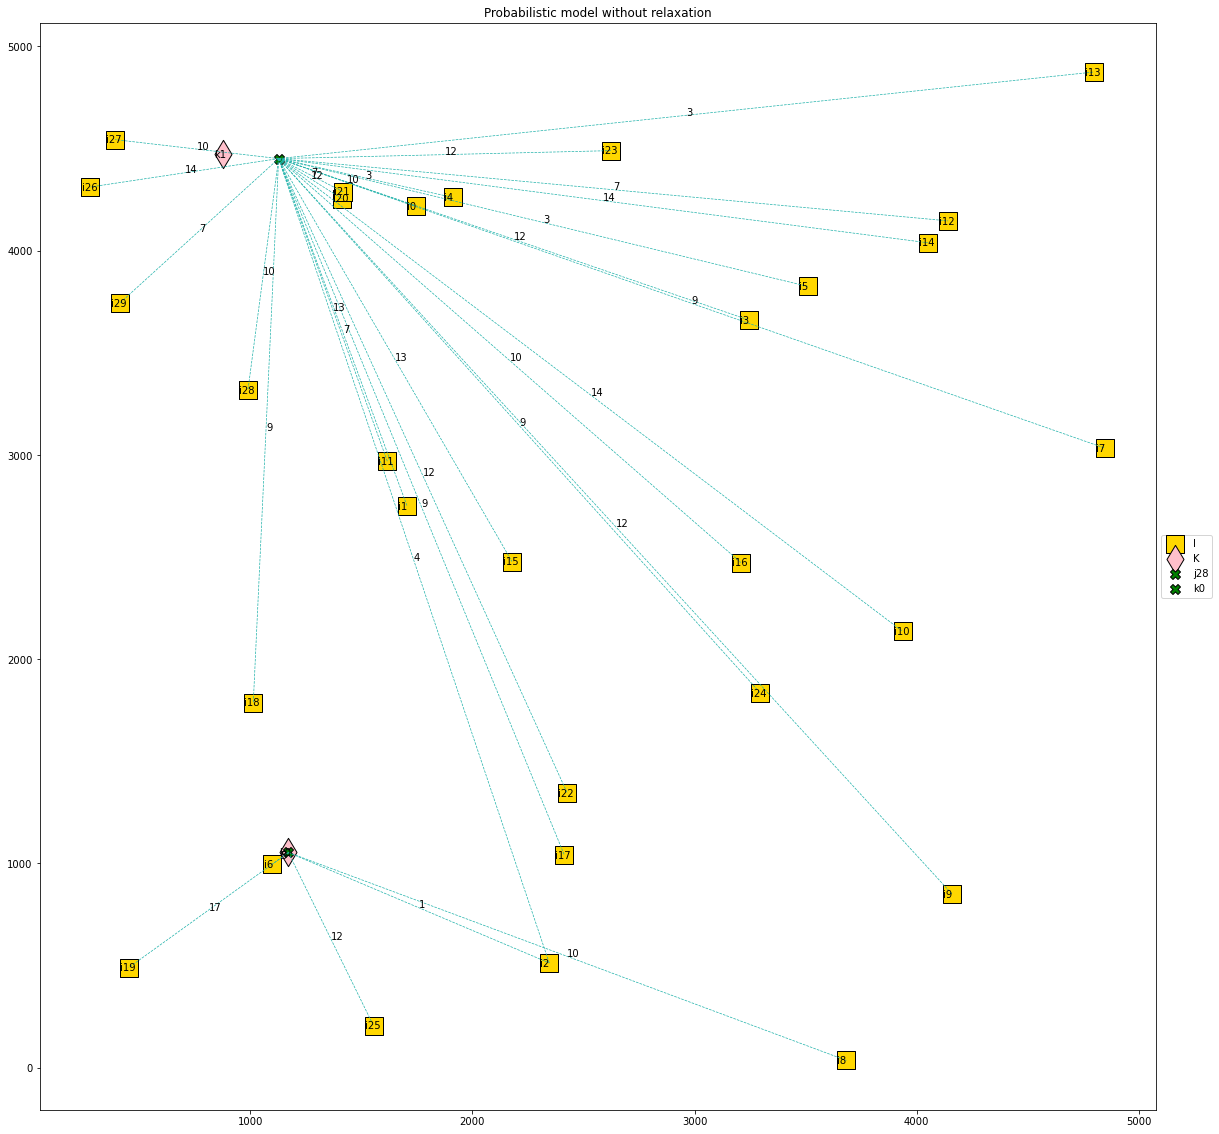

In [38]:
SolutionGraph(I, K, J, model_prob)

In [39]:
#SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob)

Probabilistic model with relaxed constraints

In [33]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),
 ('k0', 'j69'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j89'),
 ('k0', 'j90'),
 ('k0', 'j91'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j94'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j108'),
 ('k0', 'j109'),
 ('k0', 'j110'),

In [34]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))
        
P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0'),
 ('i7', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0'),
 ('i10', 'k0'),
 ('i11', 'k0'),
 ('i12', 'k0'),
 ('i13', 'k0'),
 ('i14', 'k0'),
 ('i15', 'k0'),
 ('i16', 'k0'),
 ('i17', 'k0'),
 ('i18', 'k0'),
 ('i19', 'k0'),
 ('i20', 'k0'),
 ('i21', 'k0'),
 ('i22', 'k0'),
 ('i23', 'k0'),
 ('i24', 'k0'),
 ('i25', 'k0'),
 ('i26', 'k0'),
 ('i27', 'k0'),
 ('i28', 'k0'),
 ('i29', 'k0'),
 ('i30', 'k0'),
 ('i31', 'k0'),
 ('i32', 'k0'),
 ('i33', 'k0'),
 ('i34', 'k0'),
 ('i35', 'k0'),
 ('i36', 'k0'),
 ('i37', 'k0'),
 ('i38', 'k0'),
 ('i39', 'k0'),
 ('i40', 'k0'),
 ('i41', 'k0'),
 ('i42', 'k0'),
 ('i43', 'k0'),
 ('i44', 'k0'),
 ('i45', 'k0'),
 ('i46', 'k0'),
 ('i47', 'k0'),
 ('i48', 'k0'),
 ('i49', 'k0'),
 ('i50', 'k0'),
 ('i51', 'k0'),
 ('i52', 'k0'),
 ('i53', 'k0'),
 ('i54', 'k0'),
 ('i55', 'k0'),
 ('i56', 'k0'),
 ('i57', 'k0'),
 ('i58', 'k0'),
 ('i59', 'k0'),
 ('i60', 'k0'),
 ('i61', 'k0'),
 ('i62', 'k0'),
 (

In [35]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),
 ('k0', 'j69'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j89'),
 ('k0', 'j90'),
 ('k0', 'j91'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j94'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j108'),
 ('k0', 'j109'),
 ('k0', 'j110'),

In [36]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())

In [37]:
#Redefine sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j123',
 'j124',
 'j125',
 'j126',
 'j127',
 'j128',
 'j129',
 'j130',
 'j131',
 'j142',
 'j143',
 'j144',
 'j145',
 'j146',
 'j147',
 'j148',
 'j149',
 'j150',
 'j151',
 'j152',
 'j162',
 'j163',
 'j164',
 'j165',
 'j166',
 'j167',
 'j168',
 'j169',
 'j170',
 'j171',
 'j172',
 'j173',
 'j174',
 'j175',
 'j176',
 'j177',
 'j178',
 'j179',
 'j180',
 'j181',
 'j182',
 'j183',
 'j184',
 'j185',

In [38]:
#Redifine IG, I_feasG, h_ig, phi

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in I_feasG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [39]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [40]:

model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')
model_prob_rel.addConstrs((y_j[k] == 1 for k in K.index), name = 'c7')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{'k0': <gurobi.Constr *Awaiting Model Update*>}

In [41]:
model_prob_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_prob_rel.setParam('TimeLimit', hardlimit)
model_prob_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 165410 rows, 84712 columns and 11506405 nonzeros
Model fingerprint: 0x2e150021
Variable types: 0 continuous, 84712 integer (4016 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2.744409e+07
Presolve removed 161394 rows and 19353 columns (presolve time = 8s) ...
Presolve removed 164285 rows and 19353 columns
Presolve time: 9.33s
Presolved: 1125 rows, 65359 columns, 129746 nonzeros
Variable types: 0 continuous, 65359 integer (1047 binary)
F

In [42]:
ListSolution(model_prob_rel)

Number of solutions found: 10
0
1.38645e+07 
x_ikj[i0,k0,i66] 16
x_ikj[i1,k0,j781] 9
x_ikj[i2,k0,j781] 12
x_ikj[i3,k0,j781] 9
x_ikj[i4,k0,j983] 5
x_ikj[i5,k0,j983] 10
x_ikj[i6,k0,j983] 14
x_ikj[i7,k0,j983] 13
x_ikj[i8,k0,j983] 16
x_ikj[i9,k0,j983] 9
x_ikj[i10,k0,j983] 14
x_ikj[i11,k0,j983] 13
x_ikj[i12,k0,j983] 7
x_ikj[i13,k0,j983] 7
x_ikj[i14,k0,j1034] 12
x_ikj[i15,k0,j1034] 17
x_ikj[i16,k0,j1034] 3
x_ikj[i17,k0,j1034] 14
x_ikj[i18,k0,k0] 7
x_ikj[i19,k0,j1034] 14
x_ikj[i20,k0,j1034] 10
x_ikj[i21,k0,j1034] 14
x_ikj[i22,k0,j983] 12
x_ikj[i23,k0,j983] 9
x_ikj[i24,k0,j1034] 14
x_ikj[i25,k0,j1034] 14
x_ikj[i26,k0,j983] 17
x_ikj[i27,k0,j781] 17
x_ikj[i28,k0,j781] 14
x_ikj[i29,k0,j781] 14
x_ikj[i30,k0,j781] 10
x_ikj[i31,k0,j781] 10
x_ikj[i32,k0,k0] 10
x_ikj[i33,k0,j1034] 13
x_ikj[i34,k0,j781] 4
x_ikj[i34,k0,j983] 3
x_ikj[i35,k0,j781] 10
x_ikj[i36,k0,j781] 9
x_ikj[i37,k0,j781] 7
x_ikj[i38,k0,j781] 5
x_ikj[i39,k0,j781] 5
x_ikj[i40,k0,j781] 16
x_ikj[i41,k0,j983] 9
x_ikj[i42,k0,j983] 16
x_ikj[i4

In [43]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                16
 1    i1                 9
 2   i10                14
 3   i11                13
 4   i12                 7
 ..  ...               ...
 72  i74                 9
 73  i75                10
 74  i76                13
 75   i8                16
 76   i9                 9
 
 [77 rows x 2 columns],
        j  Number of drones
 0    i66                30
 1  j1034               255
 2   j781               239
 3   j983               255
 4     k0                45,
     k  Number of drones
 0  k0               824,
 'Total number of drones: 824',
 'Total number of locations: 5')

In [44]:
#SolutionGraph(I, K, J, model_prob_rel)

In [45]:
SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob_rel)

Deterministic model with relaxed constraints

In [46]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [47]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')

model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')
model_det_rel.addConstrs((y_j[k] == 1 for k in K.index), name = 'c7')

{'k0': <gurobi.Constr *Awaiting Model Update*>}

In [48]:
model_det_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_det_rel.setParam('TimeLimit', hardlimit)
model_det_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 162518 rows, 81744 columns and 291063 nonzeros
Model fingerprint: 0xa998d95d
Variable types: 0 continuous, 81744 integer (1048 binary)
Coefficient statistics:
  Matrix range     [8e-03, 9e+04]
  Objective range  [2e+04, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 2.058524e+07
Presolve removed 161395 rows and 18166 columns
Presolve time: 0.38s
Presolved: 1123 rows, 63578 columns, 126109 nonzeros
Variable types: 0 continuous, 63578 integer (6550 binary)
Found heuristic solution: objective 1.969632e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with pri

In [49]:
ListSolution(model_det_rel)

Number of solutions found: 10
0
7.20864e+06 
x_ikj[i0,k0,j730] 10
x_ikj[i1,k0,j730] 1
x_ikj[i2,k0,j730] 6
x_ikj[i3,k0,j730] 3
x_ikj[i4,k0,j730] 1
x_ikj[i5,k0,j730] 5
x_ikj[i6,k0,j730] 11
x_ikj[i7,k0,j982] 6
x_ikj[i8,k0,j982] 7
x_ikj[i9,k0,j982] 8
x_ikj[i10,k0,j982] 1
x_ikj[i11,k0,j982] 7
x_ikj[i12,k0,j982] 5
x_ikj[i13,k0,j982] 4
x_ikj[i14,k0,j982] 4
x_ikj[i15,k0,j982] 17
x_ikj[i16,k0,j982] 2
x_ikj[i17,k0,k0] 7
x_ikj[i18,k0,k0] 2
x_ikj[i19,k0,j982] 2
x_ikj[i19,k0,k0] 3
x_ikj[i20,k0,j982] 2
x_ikj[i21,k0,j982] 5
x_ikj[i22,k0,j730] 4
x_ikj[i23,k0,j982] 2
x_ikj[i24,k0,j982] 3
x_ikj[i25,k0,j982] 10
x_ikj[i26,k0,j982] 13
x_ikj[i27,k0,j730] 10
x_ikj[i28,k0,j730] 6
x_ikj[i29,k0,j730] 10
x_ikj[i30,k0,j730] 2
x_ikj[i31,k0,j730] 6
x_ikj[i32,k0,k0] 5
x_ikj[i33,k0,j982] 2
x_ikj[i34,k0,j730] 1
x_ikj[i35,k0,j730] 2
x_ikj[i36,k0,j730] 3
x_ikj[i37,k0,j730] 5
x_ikj[i39,k0,j730] 1
x_ikj[i40,k0,j730] 11
x_ikj[i41,k0,j730] 8
x_ikj[i42,k0,j982] 16
x_ikj[i43,k0,j730] 3
x_ikj[i44,k0,k0] 4
x_ikj[i45,k0,j982] 4


In [50]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                10
 1    i1                 1
 2   i10                 1
 3   i11                 7
 4   i12                 5
 ..  ...               ...
 70  i74                 4
 71  i75                 2
 72  i76                 4
 73   i8                 7
 74   i9                 8
 
 [75 rows x 2 columns],
       j  Number of drones
 0  j730               159
 1  j982               219
 2    k0                45,
     k  Number of drones
 0  k0               423,
 'Total number of drones: 423',
 'Total number of locations: 3')

In [51]:
SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_det_rel)

In [52]:
#SolutionGraph(I, K, J, model_prob_rel)

In [53]:
#SolutionGraph(I, K, J, model_det_rel)

In [54]:
#SolutionGraph(I, K, J, model_prob)

In [55]:
#SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty

GRAPHS

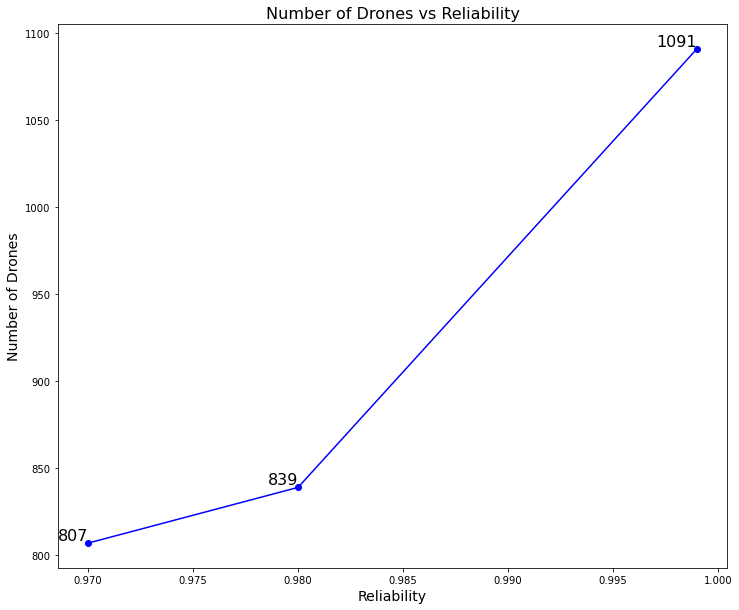

In [56]:
import matplotlib.pyplot as plt

p = [0.97, 0.98, 0.999]
number_of_drones = [807, 839, 1091]

# Plot
plt.figure(figsize=(12, 10))
plt.plot(p, number_of_drones, marker='o', color='blue', linestyle='-')
plt.title('Number of Drones vs Reliability', fontsize = 16)
plt.xlabel('Reliability', fontsize = 14)
plt.ylabel('Number of Drones', fontsize = 14)

# Add labels to points
for i in range(len(p)):
    plt.text(p[i], number_of_drones[i], f'{number_of_drones[i]}', ha='right', va='bottom', fontsize = 16)

plt.show()

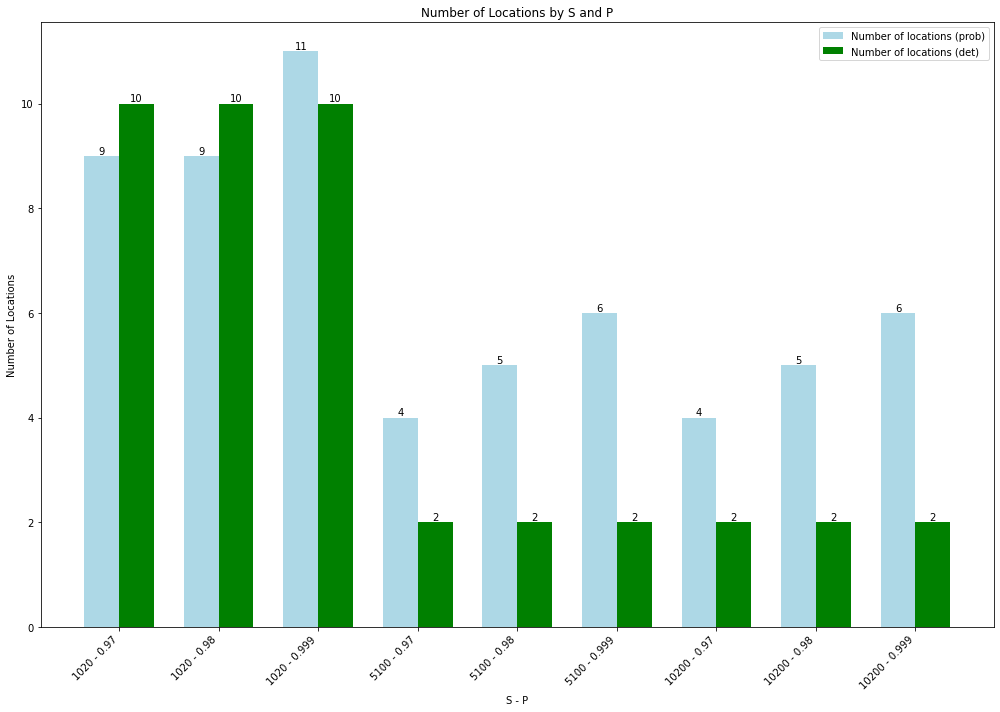

In [57]:
import numpy as np

# Data
S = [1020, 1020, 1020, 5100, 5100, 5100, 10200, 10200, 10200]
P = ['0.97', '0.98', '0.999'] * 3
locations_prob = [9, 9, 11, 4, 5, 6, 4, 5, 6]
locations_det = [10, 10, 10, 2, 2, 2, 2, 2, 2]

# Create indices for x-axis
x = np.arange(len(S))

# Width of each bar
bar_width = 0.35

# Plot
plt.figure(figsize=(14, 10))

# Plot Number of locations (prob)
bars_prob = plt.bar(x - bar_width/2, locations_prob, width=bar_width, color='lightblue', label='Number of locations (prob)')

# Plot Number of locations (det)
bars_det = plt.bar(x + bar_width/2, locations_det, width=bar_width, color='green', label='Number of locations (det)')

# Add labels and title
plt.xlabel('S - P')
plt.ylabel('Number of Locations')
plt.title('Number of Locations by S and P')
plt.xticks(x, [f'{S[i]} - {P[i]}' for i in range(len(S))], rotation=45, ha='right')
plt.legend()

# Add labels to the bars
for bars in [bars_prob, bars_det]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

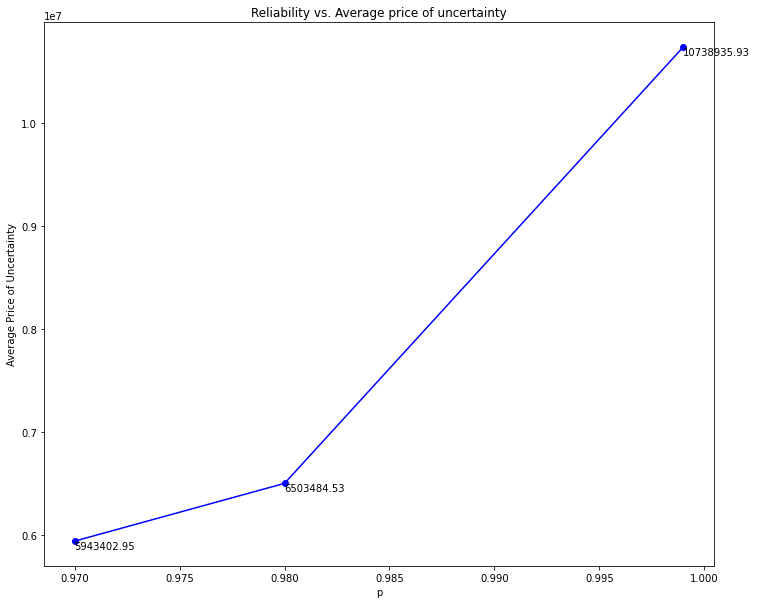

In [58]:
p = [0.97, 0.98, 0.999]
average_price = [5943402.954, 6503484.525, 10738935.93]

# Plot
plt.figure(figsize=(12, 10))
plt.plot(p, average_price, marker='o', color='blue', linestyle='-')
plt.title('Reliability vs. Average price of uncertainty')
plt.xlabel('p')
plt.ylabel('Average Price of Uncertainty')

# Add labels to points
for i in range(len(p)):
    plt.text(p[i], average_price[i], f'{average_price[i]:.2f}', ha='left', va='top')

plt.show()

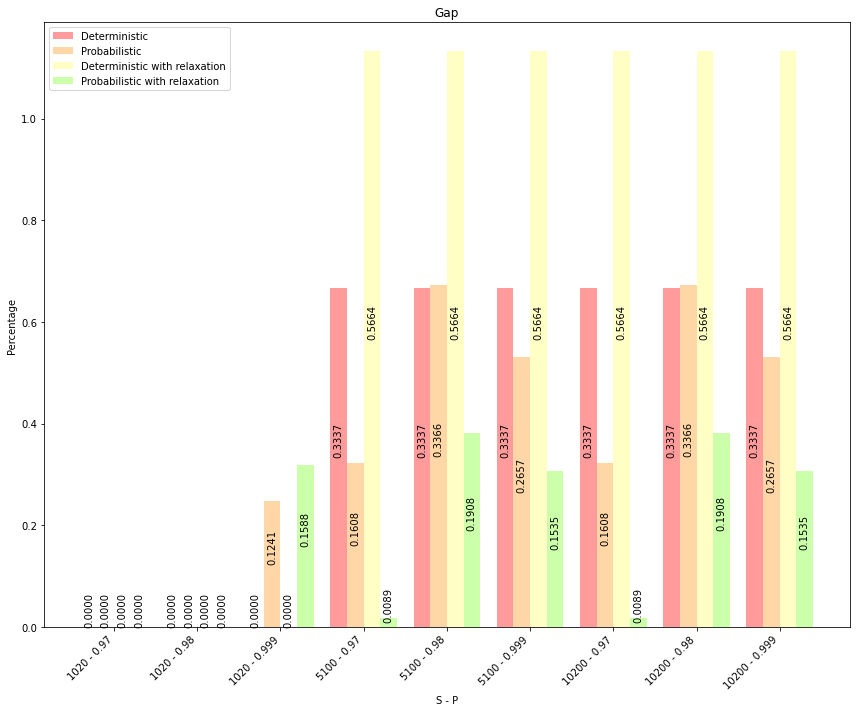

In [59]:
# Data
S = [1020, 1020, 1020, 5100, 5100, 5100, 10200, 10200, 10200]
P = ['0.97', '0.98', '0.999'] * 3
det = [0.0000, 0.0000, 0.0000, 0.6675, 0.6675, 0.6675, 0.6675, 0.6675, 0.6675]
prob = [0.0000, 0.0000, 0.2482, 0.3217, 0.6731, 0.5314, 0.3217, 0.6731, 0.5314]
det_relax = [0.0000, 0.0000, 0.0000, 1.1327, 1.1327, 1.1327, 1.1327, 1.1327, 1.1327]
prob_relax = [0.0000, 0.0000, 0.3177, 0.0177, 0.3817, 0.3070, 0.0177, 0.3817, 0.3070]

# Create indices for x-axis
x = np.arange(len(S))

# Width of each bar
bar_width = 0.2

# Plot
plt.figure(figsize=(12, 10))

# Plot Deterministic
bars_det = plt.bar(x - 1.5 * bar_width, det, width=bar_width, color='#FF9B9B', label='Deterministic')

# Plot Probabilistic
bars_prob = plt.bar(x - 0.5 * bar_width, prob, width=bar_width, color='#FFD6A5', label='Probabilistic')

# Plot Deterministic with relaxation
bars_det_relax = plt.bar(x + 0.5 * bar_width, det_relax, width=bar_width, color='#FFFEC4', label='Deterministic with relaxation')

# Plot Probabilistic with relaxation
bars_prob_relax = plt.bar(x + 1.5 * bar_width, prob_relax, width=bar_width, color='#CBFFA9', label='Probabilistic with relaxation')

# Add labels and title
plt.xlabel('S - P')
plt.ylabel('Percentage')
plt.title('Gap')
plt.xticks(x, [f'{S[i]} - {P[i]}' for i in range(len(S))], rotation=45, ha='right')
plt.legend()

# Add labels to the bars
for bars in [bars_det, bars_prob, bars_det_relax, bars_prob_relax]:
    for bar in bars:
        height = bar.get_height() / 2
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', ha='center', va='bottom', rotation = 90)

# Show plot
plt.tight_layout()
plt.show()

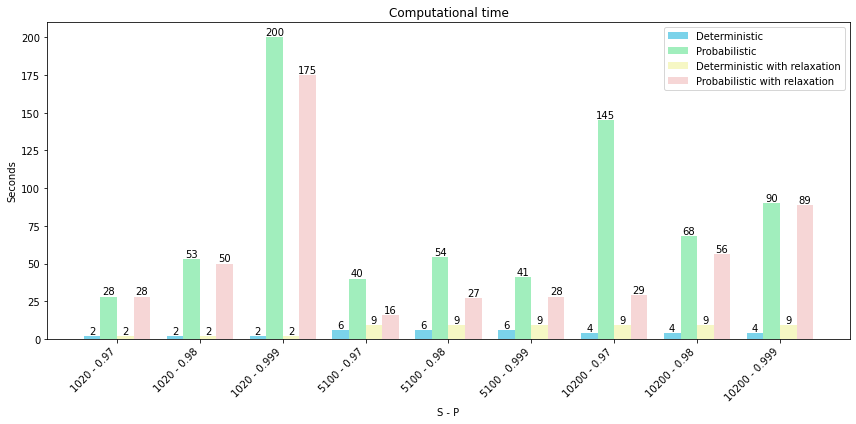

In [60]:
# Data
S = [1020, 1020, 1020, 5100, 5100, 5100, 10200, 10200, 10200]
P = ['0.97', '0.98', '0.999'] * 3
det = [2, 2, 2, 6, 6, 6, 4, 4, 4]
prob = [28, 53, 200, 40, 54, 41, 145, 68, 90]
det_relax = [2, 2, 2, 9, 9, 9, 9, 9, 9]
prob_relax = [28, 50, 175, 16, 27, 28, 29, 56, 89]

# Create indices for x-axis
x = np.arange(len(S))

# Width of each bar
bar_width = 0.2

# Plot
plt.figure(figsize=(12, 6))

# Plot Deterministic
bars_det = plt.bar(x - 1.5 * bar_width, det, width=bar_width, color='#7BD3EA', label='Deterministic')

# Plot Probabilistic
bars_prob = plt.bar(x - 0.5 * bar_width, prob, width=bar_width, color='#A1EEBD', label='Probabilistic')

# Plot Deterministic with relaxation
bars_det_relax = plt.bar(x + 0.5 * bar_width, det_relax, width=bar_width, color='#F6F7C4', label='Deterministic with relaxation')

# Plot Probabilistic with relaxation
bars_prob_relax = plt.bar(x + 1.5 * bar_width, prob_relax, width=bar_width, color='#F6D6D6', label='Probabilistic with relaxation')

# Add labels and title
plt.xlabel('S - P')
plt.ylabel('Seconds')
plt.title('Computational time')
plt.xticks(x, [f'{S[i]} - {P[i]}' for i in range(len(S))], rotation=45, ha='right')
plt.legend()

# Add labels to the bars
for bars in [bars_det, bars_prob, bars_det_relax, bars_prob_relax]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

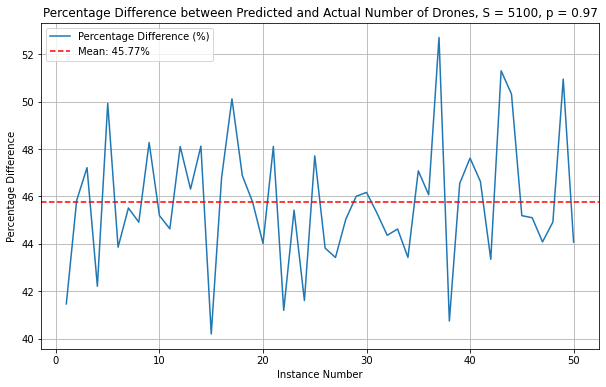

In [61]:
import matplotlib.pyplot as plt

# Provided data
model_numbers = [
    820, 816, 773, 770, 739, 700, 758, 757, 841, 759, 820, 767, 773, 694, 831, 
    735, 822, 787, 778, 727, 821, 857, 819, 834, 809, 801, 783, 817, 739, 797, 
    788, 780, 856, 753, 737, 790, 810, 837, 797, 777, 772, 789, 764, 763, 790, 
    776, 828, 797, 783, 810
]
actual_numbers = [
    480, 442, 408, 445, 370, 393, 413, 417, 435, 416, 454, 398, 415, 360, 497, 
    391, 410, 418, 422, 407, 426, 504, 447, 487, 423, 450, 443, 449, 399, 429, 
    431, 434, 474, 426, 390, 426, 383, 496, 426, 407, 412, 447, 372, 379, 433, 
    426, 463, 439, 384, 453
]

# Calculate percentage difference
percentage_difference = [((m - a) / m) * 100 for m, a in zip(model_numbers, actual_numbers)]

# Calculate mean percentage difference
mean_percentage_difference = sum(percentage_difference) / len(percentage_difference)

# Create the line graph for percentage difference
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(percentage_difference) + 1), percentage_difference, label='Percentage Difference (%)')
plt.axhline(y=mean_percentage_difference, color='r', linestyle='--', label=f'Mean: {mean_percentage_difference:.2f}%')
plt.xlabel('Instance Number')
plt.ylabel('Percentage Difference')
plt.title('Percentage Difference between Predicted and Actual Number of Drones, S = 5100, p = 0.97')
plt.legend()
plt.grid(True)
plt.show()

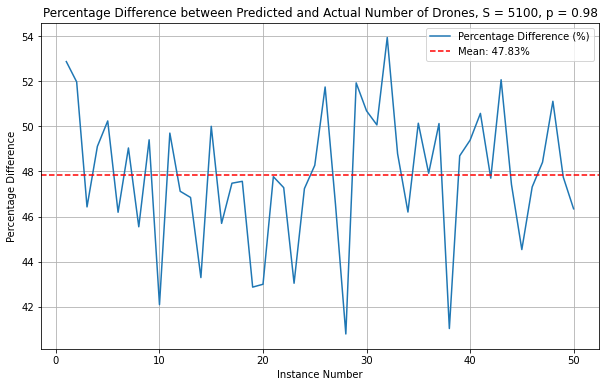

In [62]:
model_numbers = [
    872, 839, 812, 841, 842, 827, 781, 876, 836, 848, 829, 851, 777, 843, 846, 
    779, 813, 759, 807, 793, 829, 791, 755, 815, 810, 804, 825, 826, 832, 803, 
    821, 775, 781, 816, 732, 793, 818, 865, 879, 810, 787, 805, 824, 795, 824, 
    744, 816, 857, 779, 766
]

actual_numbers = [
    411, 403, 435, 428, 419, 445, 398, 477, 423, 491, 417, 450, 413, 478, 423, 
    423, 427, 398, 461, 452, 433, 417, 430, 430, 419, 388, 441, 489, 400, 396, 
    410, 357, 400, 439, 365, 413, 408, 510, 451, 410, 389, 421, 395, 418, 457, 
    392, 421, 419, 407, 411
]

# Calculate percentage difference
percentage_difference = [((m - a) / m) * 100 for m, a in zip(model_numbers, actual_numbers)]

# Calculate mean percentage difference
mean_percentage_difference = sum(percentage_difference) / len(percentage_difference)

# Create the line graph for percentage difference
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(percentage_difference) + 1), percentage_difference, label='Percentage Difference (%)')
plt.axhline(y=mean_percentage_difference, color='r', linestyle='--', label=f'Mean: {mean_percentage_difference:.2f}%')
plt.xlabel('Instance Number')
plt.ylabel('Percentage Difference')
plt.title('Percentage Difference between Predicted and Actual Number of Drones, S = 5100, p = 0.98')
plt.legend()
plt.grid(True)
plt.show()

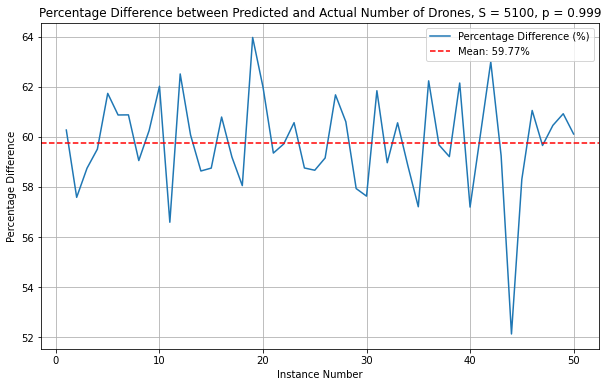

In [63]:
model_numbers = [
    1105, 1101, 1086, 1062, 1014, 1053, 1048, 1099, 1019, 1069, 1085, 1027, 1042, 
    1071, 1074, 1112, 1061, 1099, 1038, 1068, 1080, 1055, 1093, 1062, 1050, 1043, 
    1049, 1028, 1065, 1022, 1064, 987, 1070, 1013, 1096, 1091, 1116, 1064, 1070, 
    1084, 1090, 1062, 1146, 1128, 1060, 1063, 1103, 1004, 1062, 1048
]

actual_numbers = [
    439, 467, 448, 430, 388, 412, 410, 450, 405, 406, 471, 385, 416, 443, 443, 
    436, 433, 461, 374, 406, 439, 425, 431, 438, 434, 426, 402, 405, 448, 433, 
    406, 405, 422, 417, 469, 412, 450, 434, 405, 464, 435, 393, 467, 540, 442, 
    414, 445, 397, 415, 418
]

# Calculate percentage difference
percentage_difference = [((m - a) / m) * 100 for m, a in zip(model_numbers, actual_numbers)]

# Calculate mean percentage difference
mean_percentage_difference = sum(percentage_difference) / len(percentage_difference)

# Create the line graph for percentage difference
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(percentage_difference) + 1), percentage_difference, label='Percentage Difference (%)')
plt.axhline(y=mean_percentage_difference, color='r', linestyle='--', label=f'Mean: {mean_percentage_difference:.2f}%')
plt.xlabel('Instance Number')
plt.ylabel('Percentage Difference')
plt.title('Percentage Difference between Predicted and Actual Number of Drones, S = 5100, p = 0.999')
plt.legend()
plt.grid(True)
plt.show()